In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.colors as mcolors
import os
import sys
sys.path.append('/burg-archive/palab/users/wm2377/snakemake_versions/scripts/')
import simulations_10042023_classes
import pickle


In [2]:
sdist_values = ['expon']
sigma2_values = [80,40]
N2U_values = np.append(np.logspace(-3,-2,6)[:-1],np.append(np.logspace(-2,2,21),np.logspace(2,3,6)[1:]))
shift_values = [80,50]
summarized_results_paths = [f"/burg-archive/palab/users/wm2377/snakemake_versions/results/sdist_{sdist}/N2U_{N2U}/sigma2_{sigma2}/shift_{shift}/phenotypic_trajectories_summary.pickle" for sigma2 in sigma2_values for N2U in N2U_values for shift in shift_values for sdist in sdist_values]



In [3]:
### Mutation Distribution class ###
class MutationDistribution:
    def __init__(self, params):
        self.params = params
        self.name = params.sdist_name
        try:
            self.U = params.U
        except:
            self.U = params.N2U/(2*params.N)

    def cdf(self, S):
        value = 0
        for p,dist in self.params.sdist_dict.values():
            value += p*dist.cdf(S)
        return value

    def pdf(self,S):
        value = 0
        for p,dist in self.params.sdist_dict.values():
            value += p*dist.pdf(S)
        return value

    def get_random(self):
        cumulative_prob = 0
        r = np.random.random()
        for p,dist in self.params.sdist_dict.values():
            cumulative_prob += p
            if r < cumulative_prob:
                a_squared = dist.rvs()
                return a_squared
        print('failed',r,cumulative_prob,self.params.sdist_dict)

    def rvs(self):
        return self.get_random()

    def ppf(self,r):
        cumulative_prob = 0
        for p,dist in self.params.sdist_dict.values():
            print(p,cumulative_prob,cumulative_prob+p)
            if r < cumulative_prob + p:
                remaining_prob = (r-cumulative_prob)/p
                return dist.ppf(remaining_prob)
            cumulative_prob += p
        return np.inf

### Common functions ###
def variance_star(S, x):
    return 2 * S * x * (1 - x)

def folded_sojourn_time(S, x, N):
    if x < 0:
        raise ValueError
    elif x > 1 / 2:
        raise ValueError
    else:
        value = 2 * np.exp(-variance_star(S=S, x=x) / 2) / (x * (1 - x))
        if x <= 1 / (2 * N):
            return 2 * N * x * value
        else:
            return value

# gets data from the file
# data stored as {name: {sum,square_sum,n}}
def load_data(file,idk=False):
    if not idk:
        with open(file,'rb') as fin:
            return pickle.load(fin)[0]
    else:
        with open(file,'rb') as fin:
            return pickle.load(fin)

# gets array of time points
def get_t(name):
    tt = np.arange(0,20000)
    if 'd_trajectory' in name:
        return tt
    else:
        t_raw = []
        for t in tt:
            if t < 100 or (t < 500 and t % 5 == 0) or (t < 1000 and t % 10 == 0) or t % 50 == 0:
                t_raw.append(t)
        return np.array(t_raw)

# determine the mean and standard error from a list
# adds a psuedo count of one to lists of all zeros
def get_mean_and_STE_from_sums(x,x2,n):

    mean = x/n
    standard_error = np.sqrt((x2/n - mean**2)/n)
        
    return mean,standard_error

# Whether you are going to calculate DQS from the mean trajectories or the individual trajectories. Calculating from the mean trajctories is not good
def get_mean_and_STE_trimmed_scalar(data,name,all_results = False):
    if all_results == False:
        mean,standard_error = get_mean_and_STE_from_sums(x=data[name]['sum'],x2=data[name]['square_sum'],n=data[name]['n'])
    else:
        mean,standard_error = get_mean_and_STE_from_sums(x=data[name]['sum'],x2=data[name]['square_sum'],n=data['DQS_total']['n'])
    return mean,standard_error

# get the mean and standard error of the trimmed data
# trims the data to be the same length
def get_mean_and_STE_trimmed(data,name):
    t = get_t(name)
    mean,standard_error = get_mean_and_STE_from_sums(x=data[name]['sum'],x2=data[name]['square_sum'],n=data[name]['n'])
    
    min_length = min(len(mean),len(t))

    t = np.array(t)[:min_length]+1
    mean = mean[:min_length]
    standard_error = standard_error[:min_length]
    
    return np.array(mean),np.array(standard_error),np.array(t)

# get the mean trajectories
def get_mean_trajectories(data,N,sigma2):
    results_all = {}
    # Get the mean trajectories for all simulations
    # IDK what the groups are
    for groupname in ['','_group1','_group2']:
        results = {}
        
        # Get the mean trajectories for the d_trajectory
        # create a second trajectory that is just the times where we have values for the other moments
        for name in ['d_trajectory']:
            mean,standard_error,t = get_mean_and_STE_trimmed(data,name+groupname)
            trimmed_t = get_t('second_moment')
            min_length = min(len(mean),len(trimmed_t))
            trimmed_t = trimmed_t[:min_length]
            results['d_trajectory_trimmed'] = {'mean':mean[trimmed_t],'standard_error':standard_error[trimmed_t],'t':trimmed_t}
            results[name] = {'mean':mean,'standard_error':standard_error,'t':t}
    
        # Get the mean trajectories for the second and third moments
        for name in ['second_moment','third_moment']:
            mean,standard_error,t = get_mean_and_STE_trimmed(data,name+groupname)
            # Calculate the two terms from Eq. 5
            if name == 'second_moment':
                mean_transformed = (mean+sigma2)/(2*N)*results['d_trajectory_trimmed']['mean']
                standard_error_transformed = mean_transformed*((standard_error/(2*N)/mean)**2+(results['d_trajectory_trimmed']['standard_error']/results['d_trajectory_trimmed']['mean'])**2)**(0.5)
                mean = mean_transformed
                standard_error = standard_error_transformed
            elif name == 'third_moment':
                mean = mean/(2*2*N)
                standard_error = standard_error/(2*2*N)
            results[name] = {'mean':mean,'standard_error':standard_error,'t':t}
        results_all[groupname] = results
    return results_all

# search for time and distance where the QS phase starts
# Do this by averaging over windows and looking for <5% difference between the two terms
def get_DQS_value(data,window = 20):
    DQS_value = np.nan
    DQS_time = np.nan
    
    for index,d in enumerate(data['d_trajectory_trimmed']['mean'][:-window-1]):
        v = np.mean(data['second_moment']['mean'][index:index+window])
        u = np.mean(data['third_moment']['mean'][index:index+window])
        if np.isclose(v,u,rtol=0.05):
            DQS_value = d
            DQS_time = data['d_trajectory_trimmed']['t'][index]
            return DQS_value,DQS_time
    return DQS_value,DQS_time

# calculate the length of the quasi-static phase
def get_DQS_length(data,sign,DQS_time,window = 20):
    
    for index,t in enumerate(data['d_trajectory']['t'][:-window-1]):
        d = np.mean(data['d_trajectory']['mean'][index:index+window])
        if d*sign < 0.633 and t >= DQS_time:
            return t - DQS_time
    return 2e4 - DQS_time
    

def get_DQS_values_from_mean_trajectories(data,sigma2,N=5000):
    mean_trajectories_all = get_mean_trajectories(data,N,sigma2)
    
    results = {'DQS_value_trajectory':{'mean':0,'ste':0},
               'DQS_time_trajectory':{'mean':0,'ste':0},
               'DQS_length_trajectory':{'mean':0,'ste':0}}

    for groupname,mean_trajectories in mean_trajectories_all.items():
        DQS_value,DQS_time = get_DQS_value(mean_trajectories)
        DQS_length = get_DQS_length(mean_trajectories,np.sign(DQS_value),DQS_time)

        if groupname == '':
            results['DQS_value_trajectory']['mean'] = DQS_value
            results['DQS_time_trajectory']['mean'] = DQS_time
            results['DQS_length_trajectory']['mean'] = DQS_length
        else:
            
            results['DQS_value_trajectory']['ste'] += DQS_value**2
            results['DQS_time_trajectory']['ste'] += DQS_time**2
            results['DQS_length_trajectory']['ste'] += DQS_length**2

    for name in results.keys():
        square = results[name]['ste']
        mean = results[name]['mean']
        var = square - mean**2
        results[name]['ste'] = np.sqrt(var)

    return results,mean_trajectories

def main():
    
    metric_names = ['DQS_value','DQS_length','DQS_total','DQS_time']
    for metric_name in metric_names:
        fig = plt.figure(figsize=(4,4),dpi=400)
        ax = fig.add_subplot(111)
        for all_results in [False]:
            main_sub(all_results,axes=[ax],metric_names=[metric_name],summarized_results_paths=summarized_results_paths)

        
def main_sub(all_results, axes,metric_names,summarized_results_paths):
    results = {}
    metric_ylabels = {'DQS_value':r'$D_{qs}$ Distance when quasi-static phase starts','DQS_length':'Length of quasi-static phase (generations)','DQS_total':'Total directional selection','DQS_time':'Time that the quasi-static phase begins'}

    for filename in summarized_results_paths:
        
        sdist = filename.split('sdist_')[-1].split('/')[0]
        print(filename.split('N2U_')[-1].split('/')[0])
        N2U = eval(filename.split('N2U_')[-1].split('/')[0])
        sigma2 = eval(filename.split('sigma2_')[-1].split('/')[0])
        shift = eval(filename.split('shift_')[-1].split('/')[0])
        try:
            data = load_data(filename)
        except:
            print('failed to load',filename)
            continue
        refined_results = {}

        try:
            if sdist not in results:
                results[sdist] = {}
            if shift not in results[sdist]:
                results[sdist][shift] = {}
            if sigma2 not in results[sdist][shift]:
                results[sdist][shift][sigma2] = {}
            if N2U not in results[sdist][shift][sigma2]:
                results[sdist][shift][sigma2][N2U] = {}
            results[sdist][shift][sigma2][N2U] = {}

            for name in metric_names:
                mean,standard_error = get_mean_and_STE_trimmed_scalar(data=data,name=name,all_results = all_results)

                if name == 'DQS_total':
                    lande = 2*N/sigma2*shift
                    mean = mean/lande
                    standard_error = standard_error/lande
                refined_results[name] = {'mean':mean,'standard_error':standard_error}
                results[sdist][shift][sigma2][N2U][name] = {'mean':mean,'ste':standard_error}

            DQS_trajectory_dict,mean_trajectories = get_DQS_values_from_mean_trajectories(data,sigma2=sigma2,N=5000)
            results[sdist][shift][sigma2][N2U].update(DQS_trajectory_dict)
        except:
            print('failed to process',filename)
            results[sdist][shift][sigma2].pop(N2U)

    for name, ax in zip(metric_names, axes):
        if name  == 'DQS_time':
            yscale = 'log'
        else:
            yscale = 'linear'
        plot_DQS_metric(results,name,output_name = '',ylabel=metric_ylabels[name],yscale=yscale,ax=ax)
    return results

def plot_DQS_metric(results,name,output_name,ylabel='',yscale='linear',ax=None):
    plt.sca(ax)
    for sdist in results:
        for shift in results[sdist]:
            for sigma2 in results[sdist][shift]:

                if sigma2 == 80:
                    if shift == 50:
                        color = 'lightcoral'
                    else:
                        color = 'purple'
                else:
                    if shift == 80:
                        color = 'cornflowerblue'
                    else:
                        continue
                alpha = 1
                    
                x = []
                y = []
                y_err = []
                for N2U in results[sdist][shift][sigma2]:
                    try:
                        x.append(2*N2U)
                        y.append(results[sdist][shift][sigma2][N2U][name]['mean'])
                        y_err.append(results[sdist][shift][sigma2][N2U][name]['ste'])
                    except:
                        continue
                plt.errorbar(x,y,yerr=y_err,label=r'$\sigma^2 = $'+str(sigma2) + r', $\Lambda = $'+str(shift),ls='',marker='.',color=color,alpha=alpha)
        
    xlim = [3e-3,1e3]
    if name == 'DQS_value':
        ylim = [-2,12]
        plt.ylim(ylim)
        plt.plot(xlim,[0,0],ls='-',color='grey')
        plt.plot(xlim,[5,5],ls='--',color='grey')
        plt.fill_between([1e-3,1],[-2,-2],[12,12],color='lightgrey',alpha=0.5)
        plt.title(r'$\bf{D.}$ Distance when quasi-static phase starts')
    plt.xlim(xlim)
    plt.plot()
    plt.xscale('log')
    plt.xlabel('Mutational input of large effect alleles')
    plt.ylabel(ylabel)
    plt.yscale(yscale)
    plt.legend()
    # plt.show()


0.001


/local/ipykernel_2477521/1745723974.py:88: RuntimeWarning: invalid value encountered in divide
  mean = x/n
/local/ipykernel_2477521/1745723974.py:89: RuntimeWarning: invalid value encountered in divide
  standard_error = np.sqrt((x2/n - mean**2)/n)


0.001
0.001584893192461114
0.001584893192461114
0.0025118864315095794
0.0025118864315095794
0.003981071705534973
0.003981071705534973
0.006309573444801929
0.006309573444801929
0.01
0.01
0.015848931924611134
0.015848931924611134
0.025118864315095794
0.025118864315095794
0.039810717055349734
0.039810717055349734
0.06309573444801933
0.06309573444801933
0.09999999999999999
0.09999999999999999
0.1584893192461114
0.1584893192461114
0.25118864315095807
0.25118864315095807
0.3981071705534973
0.3981071705534973
0.6309573444801932
0.6309573444801932
1.0
1.0
1.584893192461114
1.584893192461114
2.511886431509582
2.511886431509582
3.9810717055349736
3.9810717055349736
6.309573444801936
6.309573444801936
10.0
10.0
15.848931924611142
15.848931924611142
25.11886431509582
25.11886431509582
39.810717055349734
39.810717055349734
63.095734448019364
63.095734448019364
100.0
100.0
158.48931924611142
158.48931924611142
251.18864315095797
251.18864315095797
398.1071705534973
398.1071705534973
630.957344480193

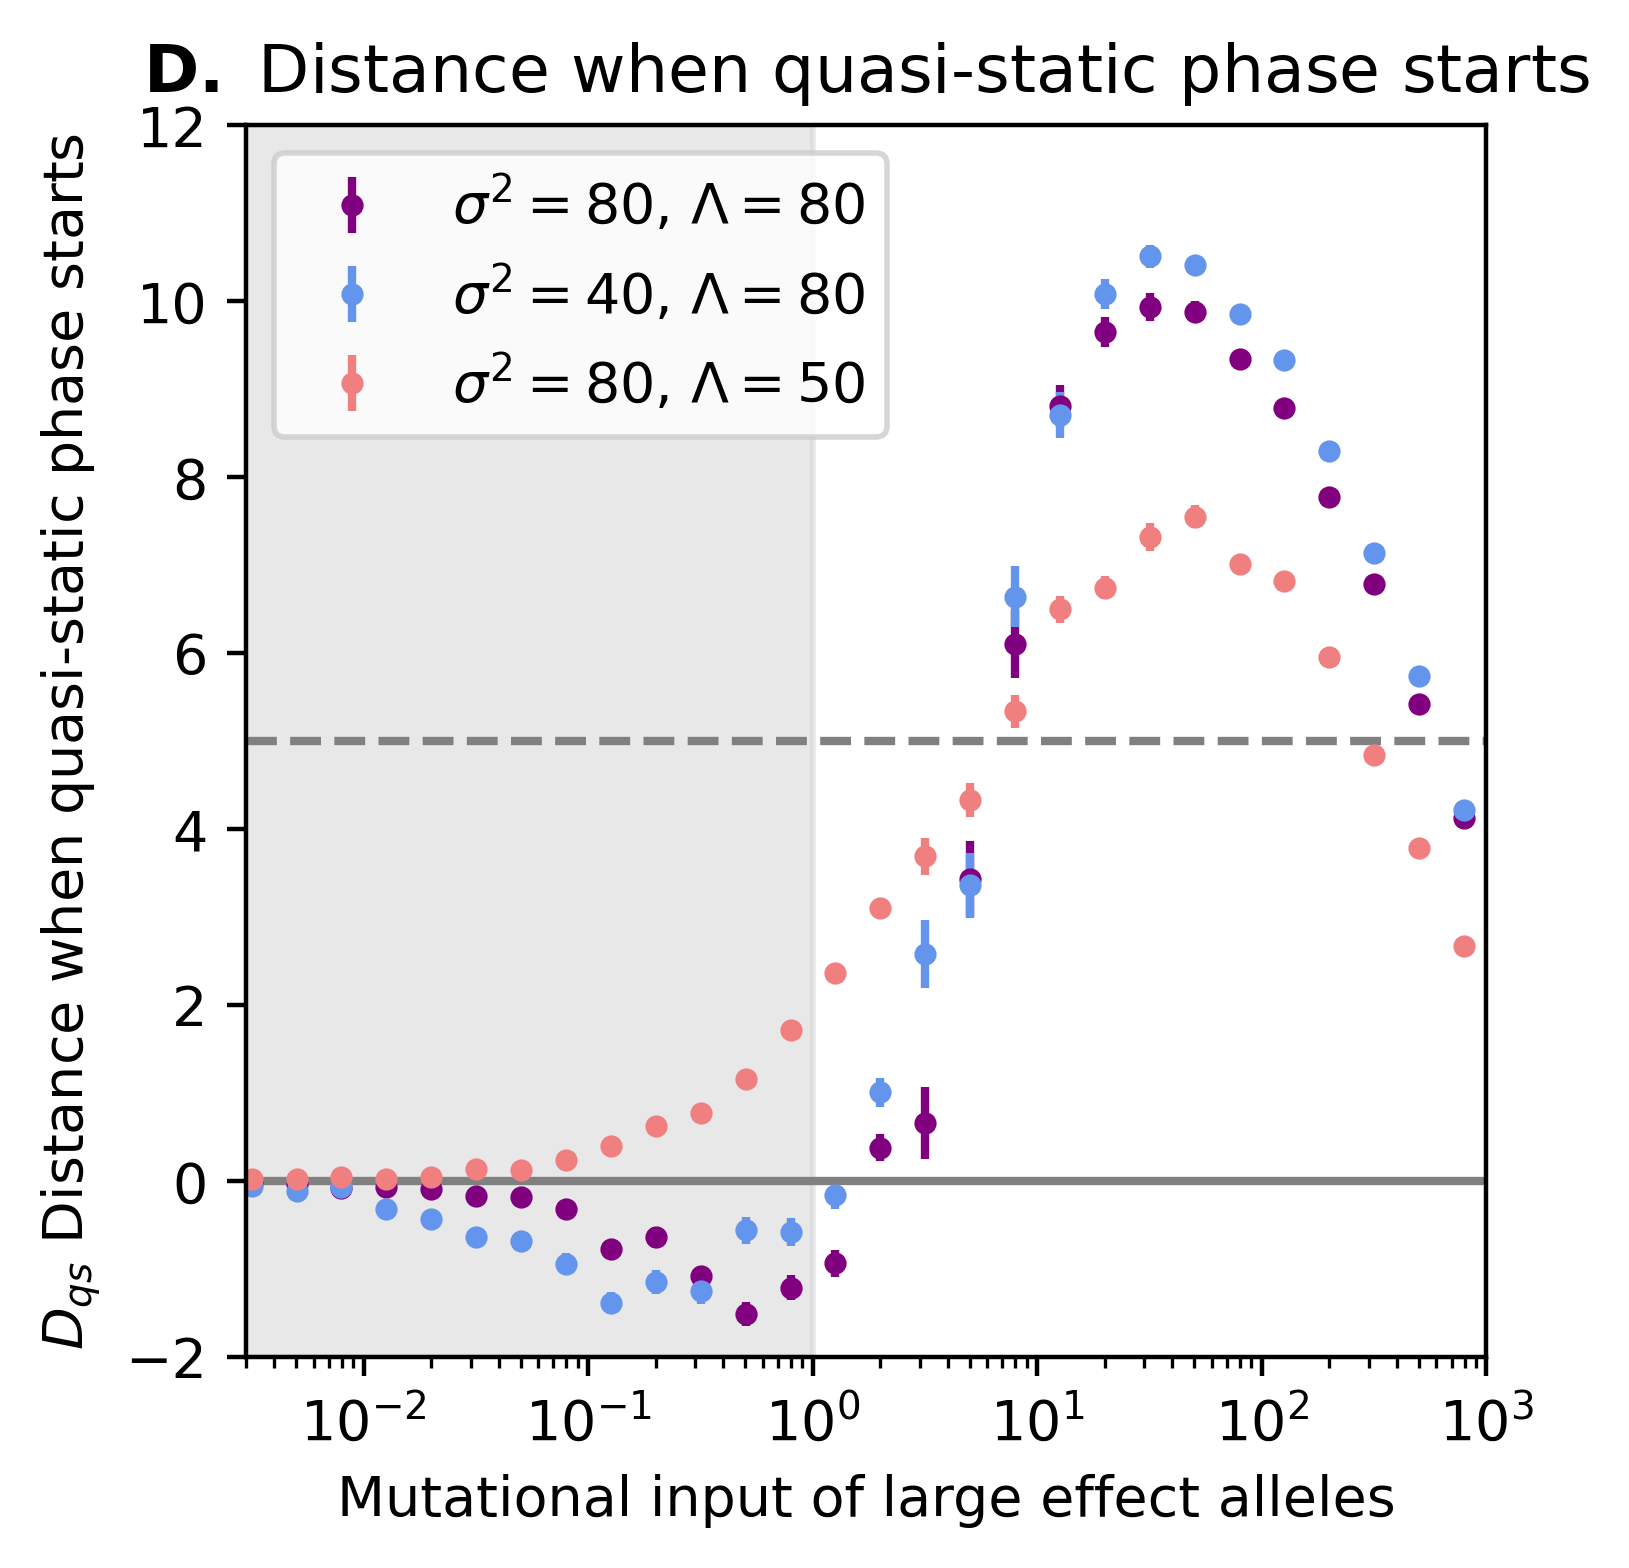

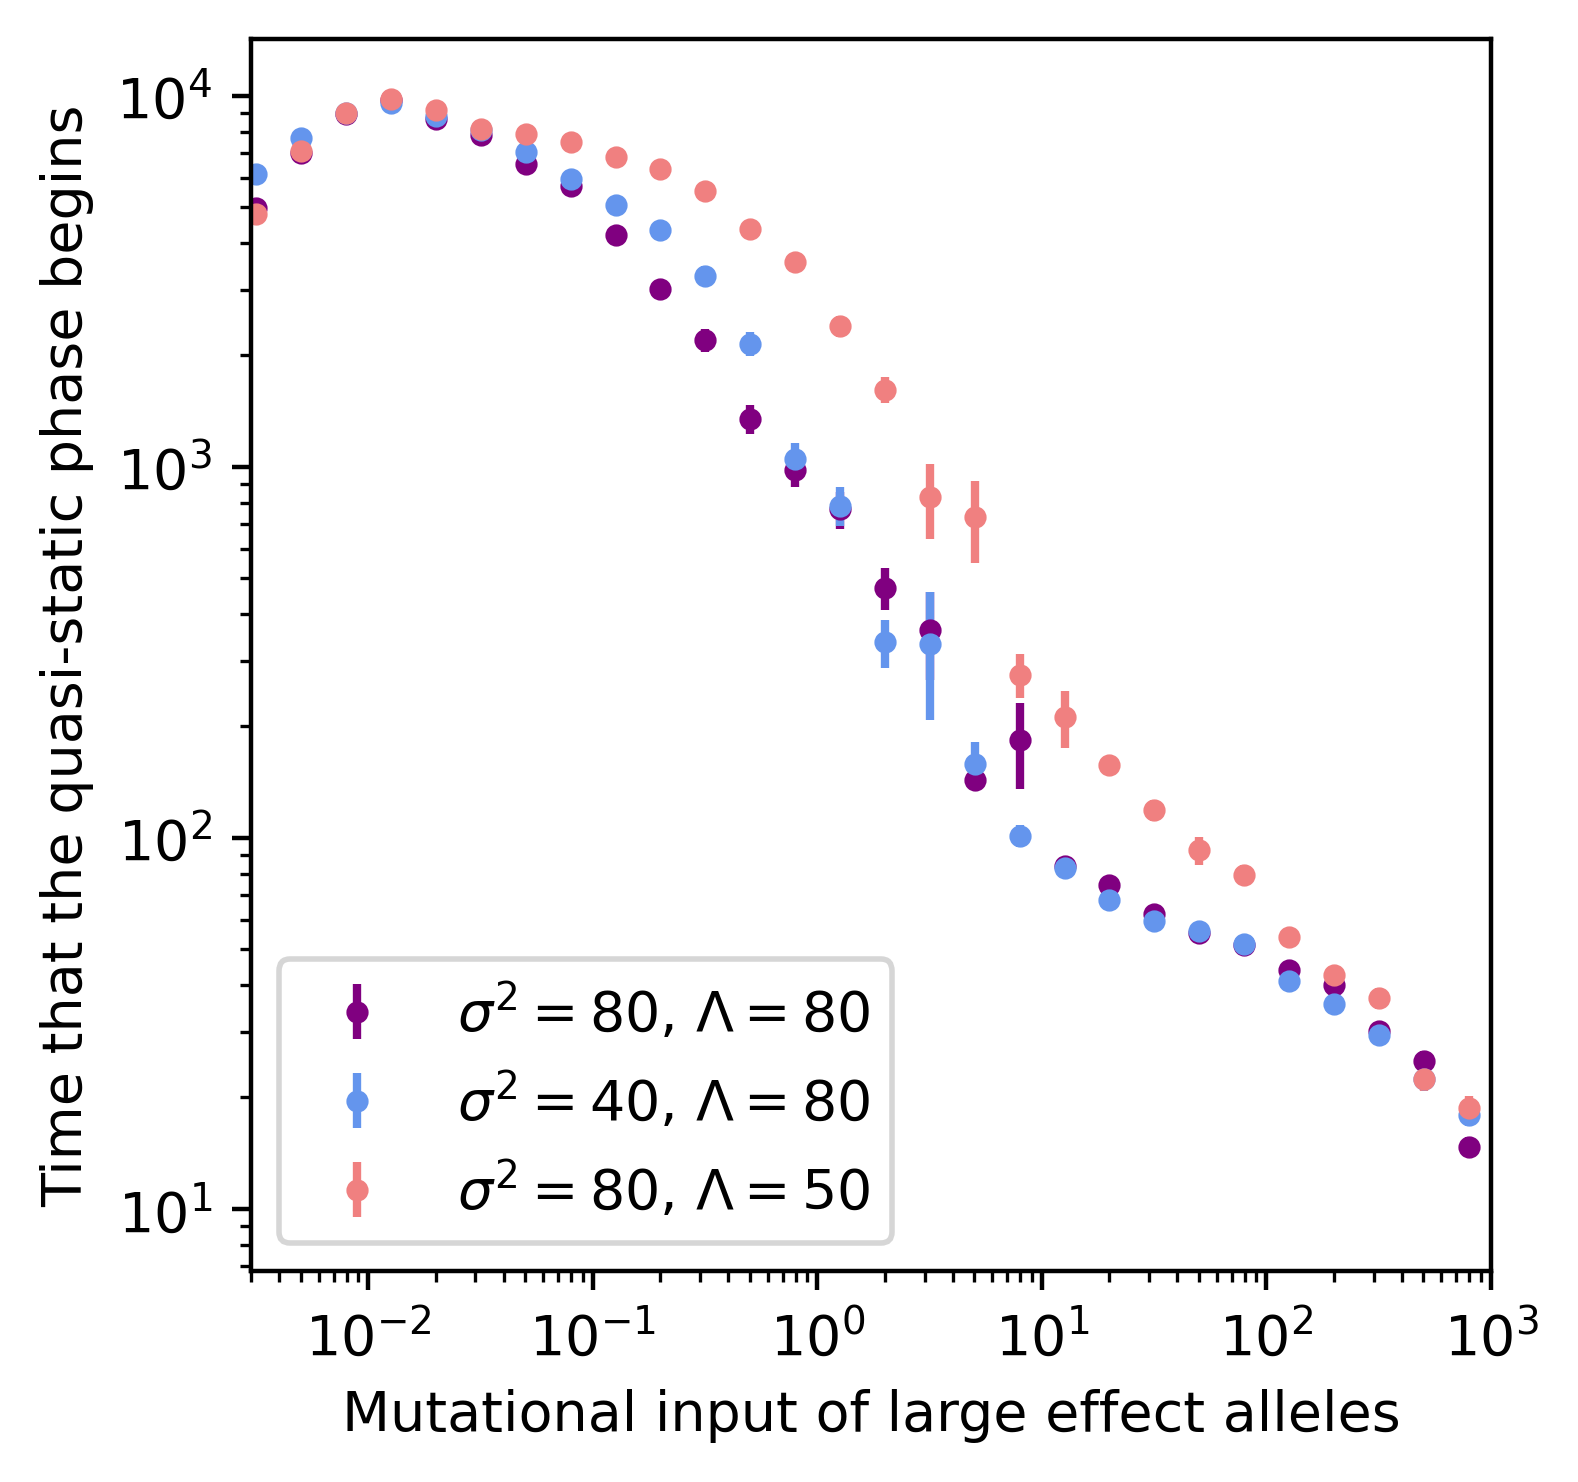

In [4]:
metric_names = ['DQS_value','DQS_time']
r = {}
for metric_name in metric_names:
    fig = plt.figure(figsize=(4,4),dpi=400)
    ax = fig.add_subplot(111)
    for all_results in [False]:
        r[metric_name]=main_sub(all_results,axes=[ax],metric_names=[metric_name],summarized_results_paths=summarized_results_paths)


In [5]:
summarized_results_directoy = "/burg-archive/palab/users/wm2377/snakemake_versions/results/sdist_expon"
# find all the files in this directory and subdirectories
import glob
summarized_results_paths = glob.glob(summarized_results_directoy + "/**/phenotypic_trajectories_summary.pickle", recursive=True)
print(summarized_results_paths)


['/burg-archive/palab/users/wm2377/snakemake_versions/results/sdist_expon/N2U_0.6309573444801932/sigma2_40/shift_50/phenotypic_trajectories_summary.pickle', '/burg-archive/palab/users/wm2377/snakemake_versions/results/sdist_expon/N2U_0.6309573444801932/sigma2_40/shift_80/phenotypic_trajectories_summary.pickle', '/burg-archive/palab/users/wm2377/snakemake_versions/results/sdist_expon/N2U_0.6309573444801932/sigma2_80/shift_50/phenotypic_trajectories_summary.pickle', '/burg-archive/palab/users/wm2377/snakemake_versions/results/sdist_expon/N2U_0.6309573444801932/sigma2_80/shift_80/phenotypic_trajectories_summary.pickle', '/burg-archive/palab/users/wm2377/snakemake_versions/results/sdist_expon/N2U_200.0/sigma2_40/shift_80/phenotypic_trajectories_summary.pickle', '/burg-archive/palab/users/wm2377/snakemake_versions/results/sdist_expon/N2U_0.1584893192461114/sigma2_40/shift_50/phenotypic_trajectories_summary.pickle', '/burg-archive/palab/users/wm2377/snakemake_versions/results/sdist_expon/N2U

2.546764408493427 2.31 3
7.55813953488372 6.685535126843617
2.476087305074524 2.31 3
7.348388131188909 6.558316340689591


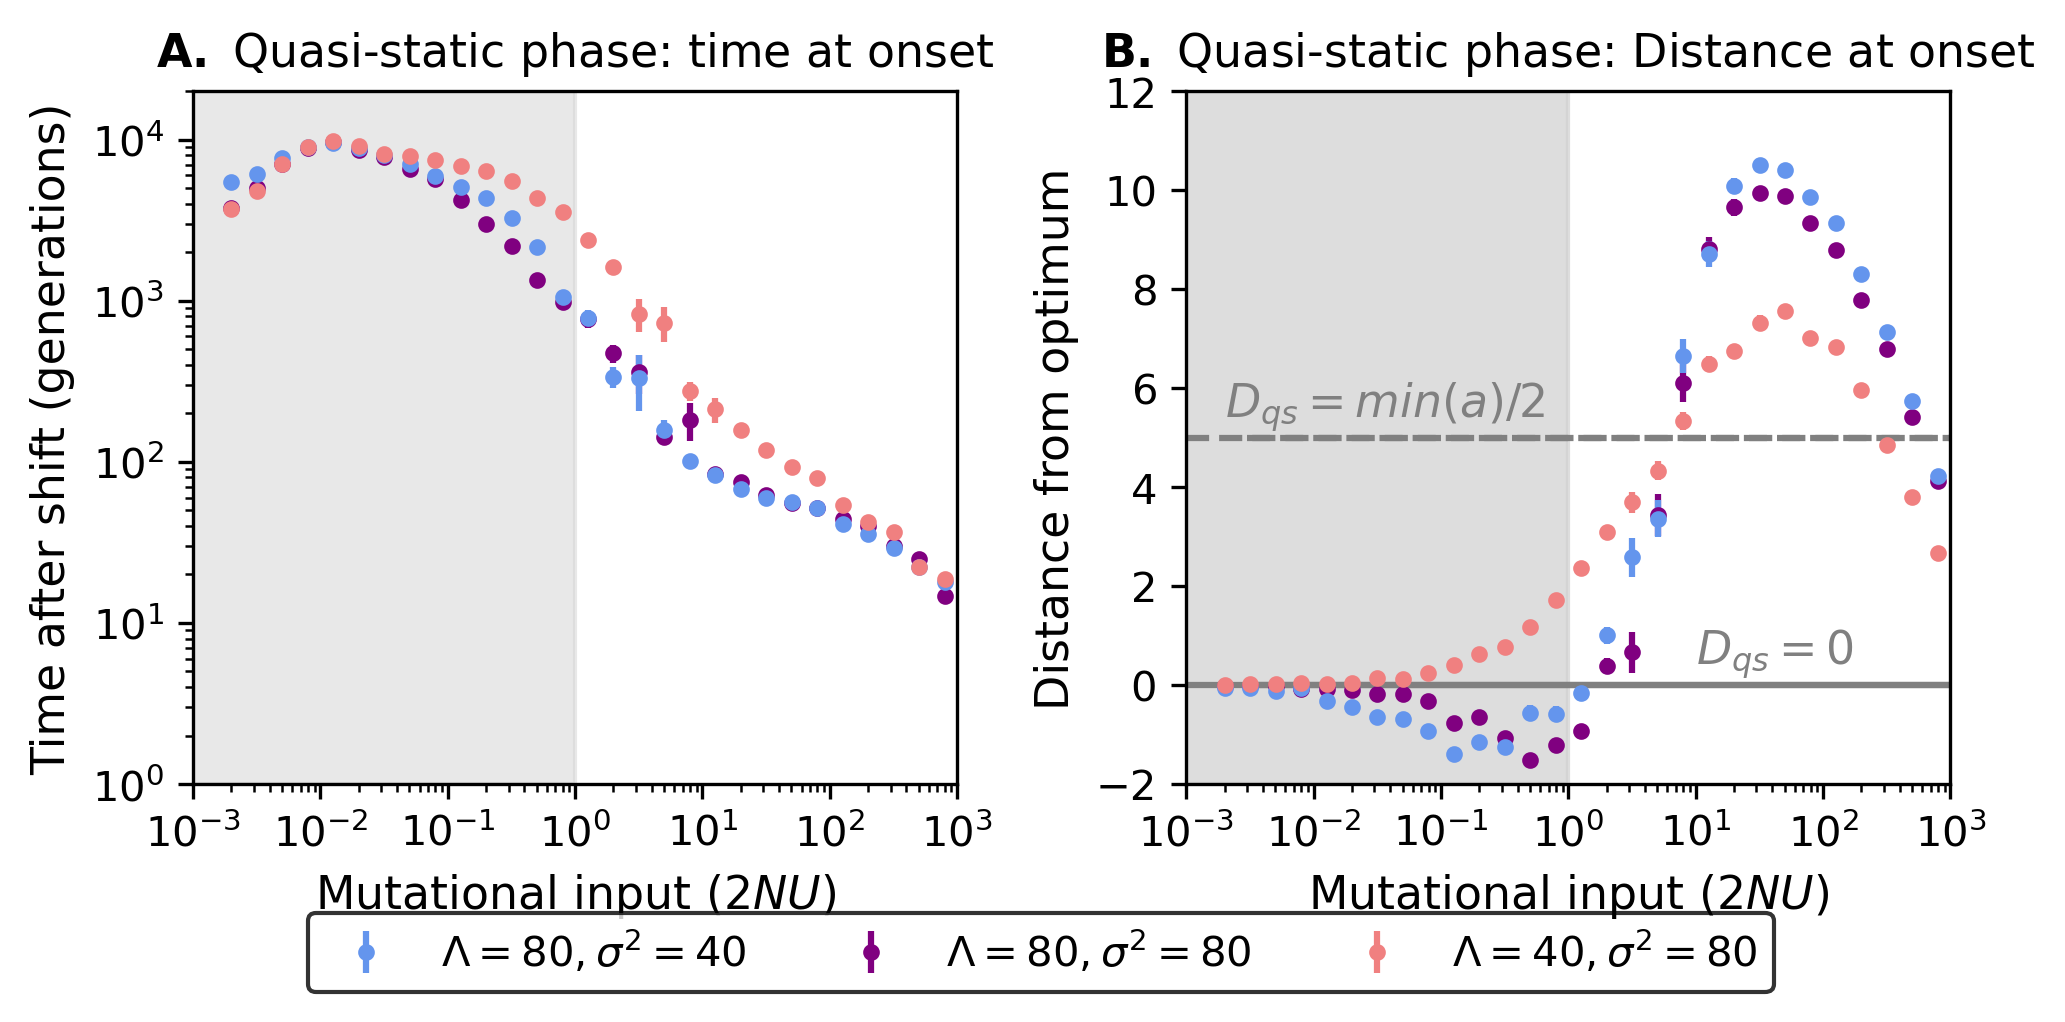

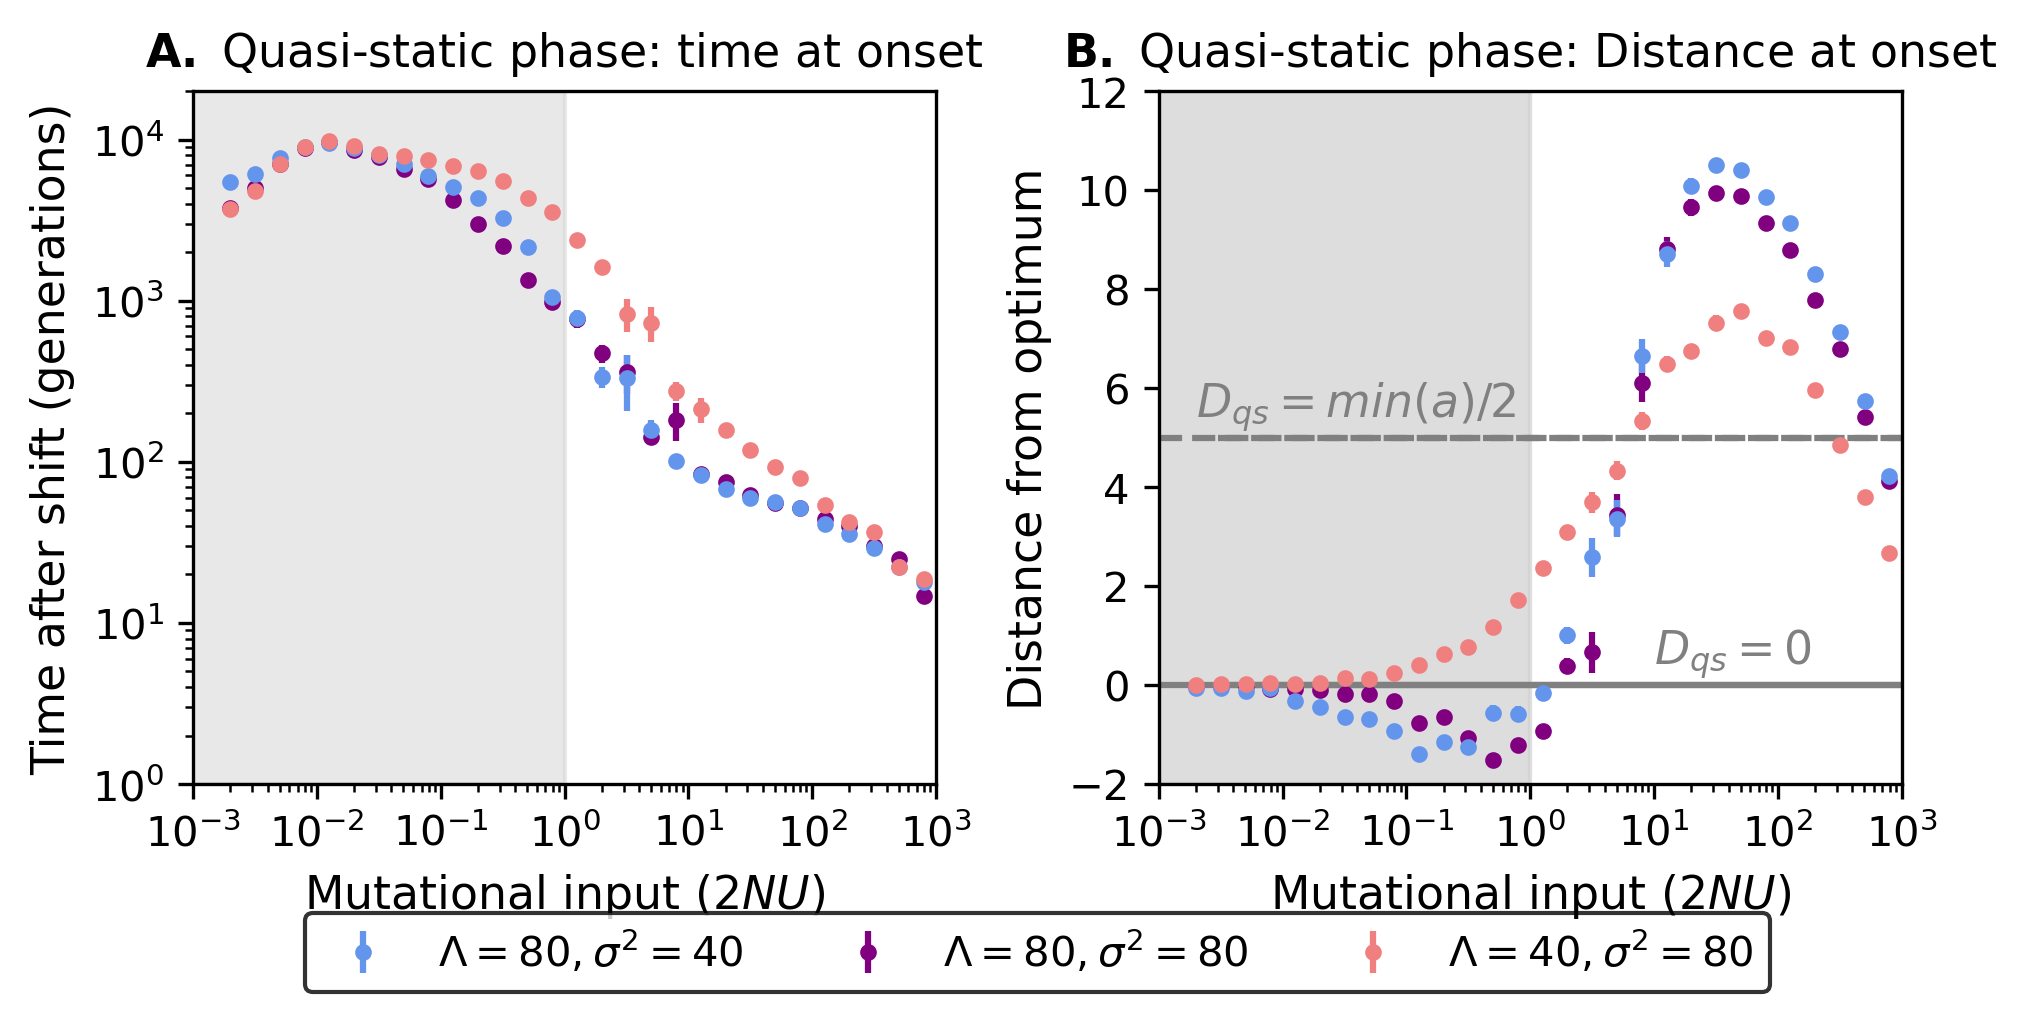

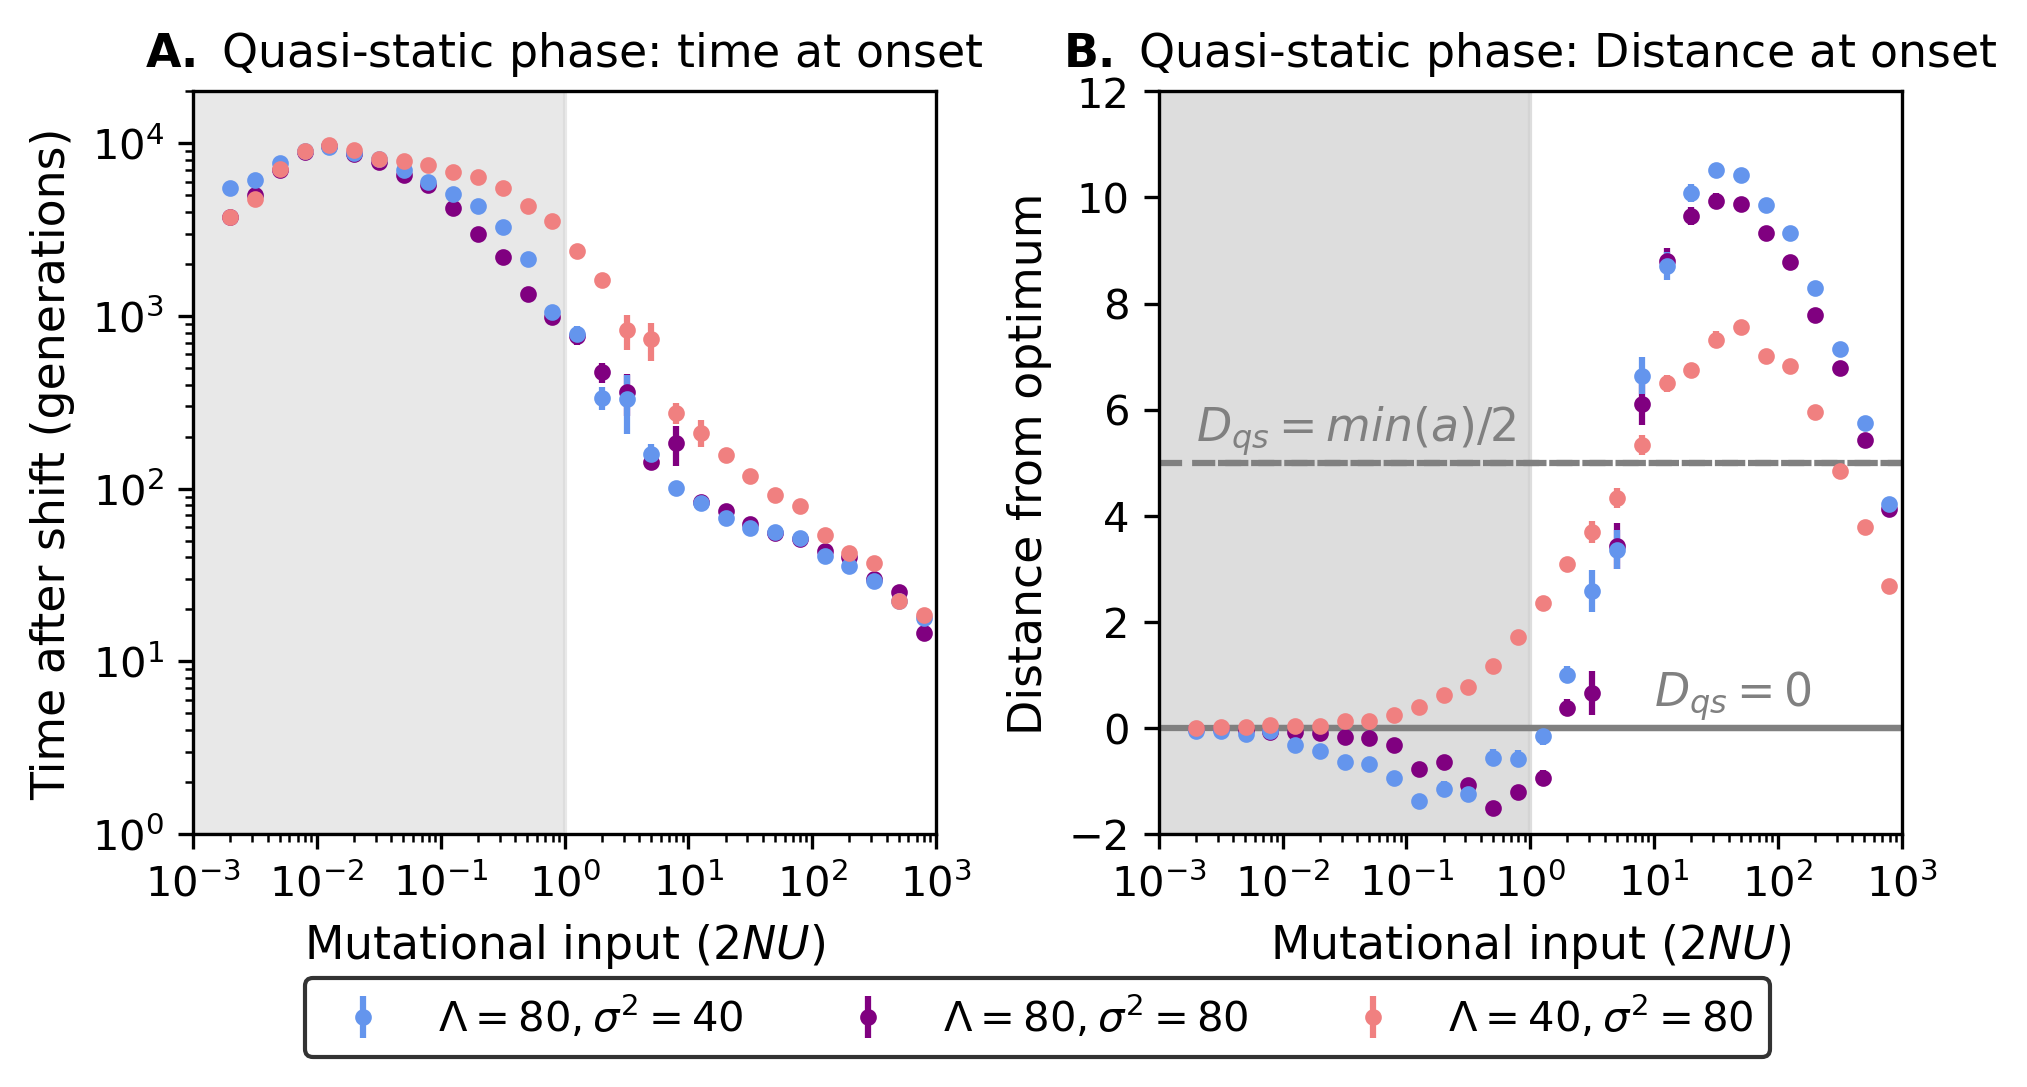

In [6]:
def make_figure_(fig_height,fig_width):    
    metric_names = ['DQS_value','DQS_time']
    fig,axes = plt.subplots(figsize=(fig_width,fig_height),dpi=300,ncols=2)
    fontsize = 11
    ax_time,ax_value= axes
    for name,results in r.items():
        if name == 'DQS_value':
            ax = ax_value
        else:
            ax = ax_time
        plot_DQS_metric(results,name,output_name = '',ylabel='',yscale='linear',ax=ax)

    ax_value.set_title(r'$\bf{B.}$ Quasi-static phase: Distance at onset',fontsize=fontsize)
    ax_value.set_yscale('linear')
    ax_value.set_ylim([-2,12])
    ax_value.set_ylabel('Distance from optimum',fontsize=fontsize)
    ax_value.set_xlabel(r'Mutational input ($2NU$)',fontsize=fontsize)
    ax_value.plot([1e-3,1e3],[0,0],ls='-',color='grey')
    ax_value.text(10,0.1,r'$D_{qs} = 0$',fontsize=fontsize,verticalalignment='bottom',color='grey')
    ax_value.plot([1e-3,1e3],[5,5],ls='--',color='grey')
    ax_value.text(2e-3,5.1,r'$D_{qs} = min(a)/2$',fontsize=fontsize,verticalalignment='bottom',color='grey')
    ax_value.fill_between([1e-3,1],[-2,-2],[12,12],color='lightgrey',alpha=0.5)
    ax_value.set_xlim([1e-3,1e3])
    ax_time.set_title(r'$\bf{A.}$ Quasi-static phase: time at onset',fontsize=fontsize)
    ax_time.set_yscale('log')
    ax_time.set_ylabel('Time after shift (generations)',fontsize=fontsize)
    ax_time.set_xlabel(r'Mutational input ($2NU$)',fontsize=fontsize)
    ax_time.fill_between([1e-3,1],[1,1],[2e4,2e4],color='lightgrey',alpha=0.5)
    ax_time.set_ylim([1,2e4])
    ax_time.set_xlim([1e-3,1e3])
    # remove legend from the right plot
    ax_value.legend_.remove()
    ax_time.legend_.remove()
    
    p1 = ax_time.errorbar([],[],[],color='cornflowerblue',ls='',marker='.',label=r'$\Lambda=80,\sigma^2=40$')
    p2 = ax_time.errorbar([],[],[],color='purple',ls='',marker='.',label=r'$\Lambda=80,\sigma^2=80$')
    p3 = ax_time.errorbar([],[],[],color='lightcoral',ls='',marker='.',label=r'$\Lambda=40,\sigma^2=80$')
    
    ax_time.legend(handles=[p1,p2,p3],edgecolor='k',loc=(0.15,-0.3),ncol=3)
    plt.subplots_adjust(wspace=0.3)
    return fig,ax_time

def make_figure_square(fig_width):
    fig_height = 3
    fig,ax = make_figure_(fig_height=fig_height,fig_width=fig_width)

    bbox = ax.get_window_extent()
    # Convert the bounding box to inches using the figure's DPI
    width_inches = bbox.width / fig.dpi
    height_inches = bbox.height / fig.dpi
    print(width_inches,height_inches,fig_height)
    if not np.isclose(width_inches,height_inches,rtol=0.01):
        fig_height = fig_height*width_inches/height_inches
        square = False
        make_figure_(fig_height=fig_height,fig_width=fig_width)
    else:
        square = True
    return fig


def make_figure_width(fig_width,depthd=0):
    if depthd > 20:
        raise ValueError
   
    fig = make_figure_square(fig_width)
    # Get the renderer for the figure canvas
    renderer = fig.canvas.get_renderer()
    # Get the tight bounding box in pixels
    tight_width_inches = fig.get_tightbbox(renderer).width
    print(fig_width,tight_width_inches)
    if np.isclose(tight_width_inches,6.5,rtol=0.01):
        plt.savefig('./Figure_S8_idk.png',dpi=300,bbox_inches='tight')
    else:
        plt.close()
        make_figure_width(fig_width=fig_width*6.5/tight_width_inches,depthd=depthd+1)

make_figure_width(fig_width=7.55813953488372)

# square = False
# height = 2.8
# while not square:
#     square,fig,height = create_figure(height)
#     if not square:
#         plt.close()
# plt.savefig('/burg-archive/home/wm2377/cdwm/snakemake_versions/Figure_S11/Figure_S11.png',dpi=300,bbox_inches='tight')

    



In [14]:
t = np.arange(0,20000)
g = np.convolve(t,np.ones(10)/10,mode='same')
dsq_t_index = np.where(np.abs((g-100000)/g) < 0.05)
print(dsq_t_index[0])


[]
